## House Sale Prediction with XGBRegressor and LGBMRegressor

Main difference between boosting algorithms xgboost and lightgbm is xgboost uses [pre-sorted algorithm](https://lightgbm.readthedocs.io/en/latest/Features.html#references). Instead, lightgbm uses histogram based algorithm which may make it more accurate and efficient.  
Again, I downloaded required data with `kaggle cli`

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb

from __future__ import print_function

# Pandas version might be an API problem for your case.
print('pandas: {}'.format(pd.__version__))
sns.set(color_codes=True)

%matplotlib inline

pandas: 0.23.4


In [2]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

In [3]:
df_train.shape

(1460, 81)

In [4]:
df_train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


Although, I don't like to see the data not to overfit, I can immediately say that ID field needs to be dropped and there are lots of NaN values.

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

/home/orhan/.local/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


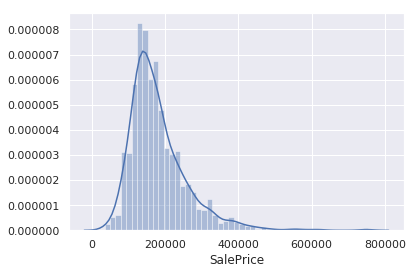

In [6]:
sns.distplot(df_train['SalePrice'])

## Feature Engineering

Removing ID and encoding categorical values.

In [7]:
test_id = df_test['Id']
df_train.drop('Id',axis=1,inplace=True)
df_test.drop('Id',axis=1,inplace=True)

So, we need log transform of SalePrice. But, why?
* Can we keep dimensions and units simple and convenient? If possible, we prefer measurement scales that are easy to think about.
* It is also about skewness of distribution and since it's a regression problem

In [8]:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

In [9]:
train_number = df_train.shape[0]
test_number = df_test.shape[0]
y_train = df_train.SalePrice.values
df_all_data = pd.concat((df_train, df_test)).reset_index(drop=True)
df_all_data.drop(['SalePrice'], axis=1, inplace=True)

/home/orhan/anaconda3/envs/shield-py-2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [10]:
df_all_data["MiscFeature"] = df_all_data["MiscFeature"].fillna("None")
df_all_data["PoolQC"] = df_all_data["PoolQC"].fillna("None")
df_all_data["Alley"] = df_all_data["Alley"].fillna("None")
df_all_data["Fence"] = df_all_data["Fence"].fillna("None")
df_all_data["LotFrontage"] = df_all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    df_all_data[col] = df_all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df_all_data[col] = df_all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df_all_data[col] = df_all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df_all_data[col] = df_all_data[col].fillna('None')
df_all_data["MasVnrType"] = df_all_data["MasVnrType"].fillna("None")
df_all_data["MasVnrArea"] = df_all_data["MasVnrArea"].fillna(0)
df_all_data['MSZoning'] = df_all_data['MSZoning'].fillna(df_all_data['MSZoning'].mode()[0])
df_all_data["Functional"] = df_all_data["Functional"].fillna("Typ")
df_all_data['Electrical'] = df_all_data['Electrical'].fillna(df_all_data['Electrical'].mode()[0])
df_all_data['KitchenQual'] = df_all_data['KitchenQual'].fillna(df_all_data['KitchenQual'].mode()[0])
df_all_data['Exterior1st'] = df_all_data['Exterior1st'].fillna(df_all_data['Exterior1st'].mode()[0])
df_all_data['Exterior2nd'] = df_all_data['Exterior2nd'].fillna(df_all_data['Exterior2nd'].mode()[0])
df_all_data['SaleType'] = df_all_data['SaleType'].fillna(df_all_data['SaleType'].mode()[0])
df_all_data['MSSubClass'] = df_all_data['MSSubClass'].fillna("None")
df_all_data["FireplaceQu"] = df_all_data["FireplaceQu"].fillna("None")

print(df_all_data.isnull().sum())

1stFlrSF         0
2ndFlrSF         0
3SsnPorch        0
Alley            0
BedroomAbvGr     0
BldgType         0
BsmtCond         0
BsmtExposure     0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtFinType1     0
BsmtFinType2     0
BsmtFullBath     0
BsmtHalfBath     0
BsmtQual         0
BsmtUnfSF        0
CentralAir       0
Condition1       0
Condition2       0
Electrical       0
EnclosedPorch    0
ExterCond        0
ExterQual        0
Exterior1st      0
Exterior2nd      0
Fence            0
FireplaceQu      0
Fireplaces       0
Foundation       0
FullBath         0
                ..
LotFrontage      0
LotShape         0
LowQualFinSF     0
MSSubClass       0
MSZoning         0
MasVnrArea       0
MasVnrType       0
MiscFeature      0
MiscVal          0
MoSold           0
Neighborhood     0
OpenPorchSF      0
OverallCond      0
OverallQual      0
PavedDrive       0
PoolArea         0
PoolQC           0
RoofMatl         0
RoofStyle        0
SaleCondition    0
SaleType         0
ScreenPorch 

In [11]:
df_all_data['MSSubClass'] = df_all_data['MSSubClass'].apply(str)

df_all_data['OverallCond'] = df_all_data['OverallCond'].astype(str)

df_all_data['YrSold'] = df_all_data['YrSold'].astype(str)
df_all_data['MoSold'] = df_all_data['MoSold'].astype(str)

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(df_all_data[c].values)) 
    df_all_data[c] = lbl.transform(list(df_all_data[c].values))

In [12]:
df_all_data = pd.get_dummies(df_all_data)

df_train = df_all_data[:train_number]
df_test = df_all_data[train_number:]

In [13]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df_train.values)
    rmse= np.sqrt(-cross_val_score(model, df_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [14]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [15]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [16]:
score = rmsle_cv(model_xgb)
print("XGBoost score: {:.3f} ({:.3f})\n".format(score.mean(), score.std()))

XGBoost score: 0.123 (0.010)



In [17]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.3f} ({:.3f})\n" .format(score.mean(), score.std()))

LGBM score: 0.123 (0.008)



In [20]:
sub = pd.DataFrame()
sub['Id'] = test_id
model_lgb.fit(df_train, y_train)
sub['SalePrice'] = np.expm1(model_lgb.predict(df_test.values))
sub.to_csv('submission.csv',index=False)